In [1]:
import os
import numpy as np
import onnxruntime as rt
import onnx
import matplotlib.pyplot as plt
from train.dataloader import CommaDataset, BatchDataLoader, BackgroundGenerator
from torch.utils.data import DataLoader
import cv2
import time
from utils import Calibration, draw_path, FULL_FRAME_SIZE, create_img_plot_canvas
from matplotlib.patches import Patch


In [23]:
plot_img_height, plot_img_width = 360, 480 # can be reduced for wandb
fill_color_gt = [0,  255, 0]
line_color_gt = [255,255, 0]
fill_color_preds = [0,  0,255]
line_color_preds = [200,0,255]

In [3]:
def legend_color(color, opacity=0.3):
    return np.append(np.array(color)/255, opacity)


def seperate_points_and_std_values(path):
    points_indices = np.arange(0, path.shape[-1], 2)
    std_indices = np.arange(1, path.shape[-1], 2)

    points = path[:, points_indices]
    std_values = path[:, std_indices]

    return points, std_values


def extract_preds(res):
    # N is batch_size

    plan_start_idx = 0
    plan_end_idx = 4955

    lanes_start_idx = plan_end_idx
    lanes_end_idx = lanes_start_idx + 528

    lane_lines_prob_start_idx = lanes_end_idx
    lane_lines_prob_end_idx = lane_lines_prob_start_idx + 8

    road_start_idx = lane_lines_prob_end_idx
    road_end_idx = road_start_idx + 264

    plan = res[:, plan_start_idx:plan_end_idx]  # (N, 4955)
    paths = np.array(np.split(plan, 5, axis=1)).reshape(-1, 5, 991)  # (N, 5, 991)
    path_probs = paths[:, :, -1]  # (N, 5)
    paths = paths[:, :, :-1].reshape(-1, 5, 2, 33, 15)  # (N, 5, 2, 33, 15)

    best_idx = np.argmax(path_probs, axis=1)[0]  # (N,)
    best_path = paths[:, best_idx, ...]  # (N, 2, 33, 15)

    lanes = res[:, lanes_start_idx:lanes_end_idx]
    lane_road = res[:, road_start_idx:road_end_idx]

    ll_t = lanes[:, 0:66]

    ll_t2 = lanes[:, 66:132]
    outer_left_lane, outer_left_lane_std = seperate_points_and_std_values(ll_t)
    inner_left_lane, inner_left_lane_std = seperate_points_and_std_values(ll_t2)

    l_t = lanes[:, 132:198]
    l_t2 = lanes[:, 198:264]
    outer_right_lane, outer_right_lane_std = seperate_points_and_std_values(l_t2)
    inner_right_lane, inner_right_lane_std = seperate_points_and_std_values(l_t)

    roadr_t = lane_road[:, 0:66]
    roadr_t2 = lane_road[:, 66:132]
    left_road_edge, left_road_edge_std = seperate_points_and_std_values(roadr_t)
    right_road_edge, right_road_edge_std = seperate_points_and_std_values(roadr_t2)

    # lanelines with std
    lanelines = [
        # (left_road_edge, left_road_edge_std, 'yellow'),
        # (outer_left_lane,  outer_left_lane_std, 'sandybrown'),
        (inner_left_lane,  inner_left_lane_std, 'white'),
        (inner_right_lane, inner_right_lane_std, 'white'),
        # (outer_right_lane, outer_right_lane_std, 'sandybrown'),
        # (right_road_edge, right_road_edge_std, 'yellow'),
    ]

    return lanelines, best_path

In [4]:
real_preds = np.load('/home/nikita/data/2021-09-14--09-19-21/25/xyz_preds.npz')
real_paths_xyz = np.stack((real_preds['x'], real_preds['y'], real_preds['z']), axis=-1)
real_paths_xyz.shape

(1200, 33, 3)

#### Extract `seq_len`-th input_frame and bgr_frame from video:

In [5]:
comma_recordings_basedir = '/home/nikita/data'
path_to_onnx_model = 'train/supercombo.onnx'
os.makedirs('outs', exist_ok=True)

train_split = 0.8
seq_len = 1190
single_frame_batches = False
prefetch_factor = 1
batch_size = 1
num_workers = 1

train_dataset = CommaDataset(comma_recordings_basedir, train_split=train_split, seq_len=seq_len,
                                shuffle=True, single_frame_batches=single_frame_batches, seed=42)
train_loader = DataLoader(train_dataset, batch_size=None, num_workers=num_workers, shuffle=False,
                        prefetch_factor=prefetch_factor, persistent_workers=True, collate_fn=None)
train_loader = BatchDataLoader(train_loader, batch_size=batch_size)
# train_loader = BackgroundGenerator(train_loader) # removed only for this example, keep in production

input_frames_history = []
bgr_frames_history = []

for batch in train_loader:
    stacked_frames, plans, plans_probs, segment_finished, sequence_finished, bgr_frames = batch

    for t_idx in range(seq_len):

        input_frame = stacked_frames[0:1, t_idx, ...].numpy().astype(np.float32)
        bgr_frame = bgr_frames[0, t_idx, ...].numpy()

        input_frames_history.append(input_frame)
        bgr_frames_history.append(bgr_frame)

    break

Using cached paths to videos and GTs...
Total # segments 72
Subset # segments: 58


In [6]:
model = onnx.load(path_to_onnx_model)

input_names = [node.name for node in model.graph.input]
output_names = [node.name for node in model.graph.output]

providers = ['CPUExecutionProvider']
onnxruntime_model = rt.InferenceSession(path_to_onnx_model, providers=providers)


In [7]:
path_preds = []

recurrent_state = np.zeros((1, 512), dtype=np.float32)

for t_idx in range(200):
    inputs = {
        'input_imgs': input_frames_history[t_idx],
        'desire': np.zeros((1, 8), dtype=np.float32),
        'traffic_convention': np.array([0, 1], dtype=np.float32).reshape(1, 2),
        'initial_state': recurrent_state,
    }

    outs = onnxruntime_model.run(output_names, inputs)[0]
    lanelines, best_path = extract_preds(outs)  # TODO: visualize these lanelines as well
    recurrent_state = outs[:, -512:]
    path_xyz_pred = best_path[0, 0, :, :3]
    path_preds.append(path_xyz_pred)

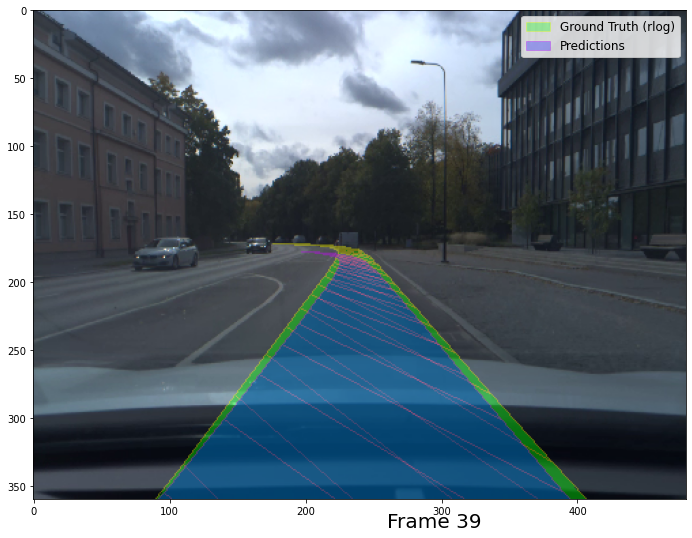

In [25]:
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
import matplotlib.animation as animation
from IPython.display import HTML


plot_width = 12
plot_height = plot_width * (FULL_FRAME_SIZE[1] / FULL_FRAME_SIZE[0])
fig, ax = plt.subplots(1,1, figsize=(plot_width, plot_height))
legend_elements = [Patch(facecolor=legend_color(fill_color_gt), edgecolor=legend_color(line_color_gt),
                                label='Ground Truth (rlog)'),
                        Patch(facecolor=legend_color(fill_color_preds), edgecolor=legend_color(line_color_preds),
                                label='Predictions')]


def animate(t_idx):
    # plot predictions
    rgb_frame = cv2.cvtColor(bgr_frames_history[t_idx], cv2.COLOR_BGR2RGB)

    rpy_calib_gt = [0.00018335809, 0.034165092, -0.014245722]  # real calibration values during this ride
    rpy_calib_pred = [0, 0, 0]  # calibration we currently use for pre-processing

    calibration_gt = Calibration(rpy_calib_gt, plot_img_width=plot_img_width, plot_img_height=plot_img_height)
    calibration_pred = Calibration(rpy_calib_pred, plot_img_width=plot_img_width, plot_img_height=plot_img_height)

    path_xyz_gt = real_paths_xyz[t_idx]
    path_xyz_pred = path_preds[t_idx]

    img_plot = create_img_plot_canvas(rgb_frame, calibration_gt) # calibration here doesn't really matter, just has to have the right plot_img_width and plot_img_height for correct scaling
    img_plot = draw_path(path_xyz_gt, img_plot, calibration_gt, fill_color=fill_color_gt, line_color=line_color_gt)
    img_plot = draw_path(path_xyz_pred, img_plot, calibration_pred, fill_color=fill_color_preds, line_color=line_color_preds)    

    ax.clear()
    txt = ax.text(plot_img_height-100, plot_img_width-100, f'Frame {t_idx}', fontsize=20)
    plt_img = ax.imshow(img_plot)
    legend = ax.legend(handles=legend_elements, loc='upper right', prop={'size': 12})

    return txt, plt_img, legend

anim = FuncAnimation(fig, animate, interval=1000/20, blit=True, repeat=True, frames=len(path_preds)//5)  
writer = FFMpegWriter(fps=20, bitrate=2000)
anim.save("outs/TLI.gif", writer=writer)